In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

In [120]:
#Define the number of elememts in each set I, J, K
i_num = 25
k_num = 1
j_num = 100 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])


In [121]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 100), 4)
    I.loc[i, 'Longtitude'] = round(random.uniform(0, 100), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 100), 4)
    K.loc[k, 'Longtitude'] = round(random.uniform(0, 100), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 100), 4)
    J.loc[j, 'Longtitude'] = round(random.uniform(0, 100), 4)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
I.index

Index(['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10',
       'i11', 'i12', 'i13', 'i14', 'i15', 'i16', 'i17', 'i18', 'i19', 'i20',
       'i21', 'i22', 'i23', 'i24'],
      dtype='object', name='Point number')

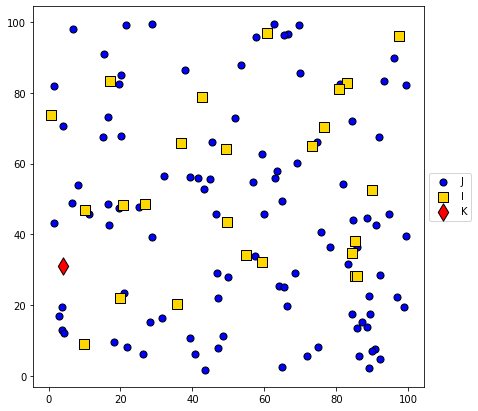

In [122]:
axs, fig = plt.subplots(1, 1, figsize = (7, 7))

fig.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [123]:
#Define constants

B = 200
S = 20
alpha = 10

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400
    else:
        beta[j] = 300
        
q_j = {j: 50 for j in J.index}
up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

mu

{'i0': 7,
 'i1': 2,
 'i2': 2,
 'i3': 5,
 'i4': 3,
 'i5': 8,
 'i6': 10,
 'i7': 6,
 'i8': 2,
 'i9': 6,
 'i10': 10,
 'i11': 4,
 'i12': 9,
 'i13': 7,
 'i14': 3,
 'i15': 1,
 'i16': 1,
 'i17': 1,
 'i18': 7,
 'i19': 11,
 'i20': 10,
 'i21': 2,
 'i22': 3,
 'i23': 11,
 'i24': 3}

Deterministic model

In [124]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 4,
 'i1': 0,
 'i2': 0,
 'i3': 6,
 'i4': 4,
 'i5': 8,
 'i6': 9,
 'i7': 4,
 'i8': 0,
 'i9': 4,
 'i10': 10,
 'i11': 2,
 'i12': 10,
 'i13': 4,
 'i14': 2,
 'i15': 0,
 'i16': 2,
 'i17': 2,
 'i18': 5,
 'i19': 15,
 'i20': 10,
 'i21': 2,
 'i22': 2,
 'i23': 11,
 'i24': 4}

In [125]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longtitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longtitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 85.99466330604474,
 ('k0', 'j1'): 89.8268627047611,
 ('k0', 'j2'): 63.26521610569271,
 ('k0', 'j3'): 74.33557988641778,
 ('k0', 'j4'): 18.60344138109936,
 ('k0', 'j5'): 86.39629248648347,
 ('k0', 'j6'): 48.486317080595015,
 ('k0', 'j7'): 74.448788525066,
 ('k0', 'j8'): 71.07218370565238,
 ('k0', 'j9'): 65.27558283592725,
 ('k0', 'j10'): 40.72400689924802,
 ('k0', 'j11'): 25.92775521810556,
 ('k0', 'j12'): 89.82071903130146,
 ('k0', 'j13'): 87.57952999674067,
 ('k0', 'j14'): 43.78252601438158,
 ('k0', 'j15'): 60.30676968052592,
 ('k0', 'j16'): 18.09897645420867,
 ('k0', 'j17'): 94.3925343315879,
 ('k0', 'j18'): 90.6023735941835,
 ('k0', 'j19'): 66.83373440419142,
 ('k0', 'j20'): 91.85778268589982,
 ('k0', 'j21'): 17.104134071036743,
 ('k0', 'j22'): 64.33988442676906,
 ('k0', 'j23'): 79.17505449906555,
 ('k0', 'j24'): 44.92000494312084,
 ('k0', 'j25'): 72.21586230988314,
 ('k0', 'j26'): 46.00592496766042,
 ('k0', 'j27'): 31.00885082053187,
 ('k0', 'j28'): 57.74419812327468

In [126]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 (

In [127]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas


[('k0', 'j2'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j55'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j68'),
 ('k0', 'j69'),
 ('k0', 'j70'),
 ('k0', 'j72'),

In [128]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [129]:
model_det = gp.Model('Deterministic model')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [130]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{('k0', 'j35', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j35', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j35', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j43', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j43', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j43', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j63', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j63', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j63', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j63', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j67', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j67', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j67', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j67', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j68', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j68', 'i16'): <gurobi.Constr *Aw

In [131]:
model_det.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 223 rows, 3176 columns and 865 nonzeros
Model fingerprint: 0x82337731
Variable types: 0 continuous, 3176 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+02]
Found heuristic solution: objective 8460.0000000
Presolve removed 91 rows and 2777 columns
Presolve time: 0.00s
Presolved: 132 rows, 399 columns, 686 nonzeros
Variable types: 0 continuous, 399 integer (112 binary)

Root relaxation: objective 2.672448e+03, 282 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

    

In [132]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 8
0
3160 
x_ikj[i0,k0,j25] 4
x_ikj[i3,k0,i14] 6
x_ikj[i4,k0,j25] 4
x_ikj[i5,k0,i14] 8
x_ikj[i6,k0,i6] 9
x_ikj[i7,k0,i7] 4
x_ikj[i9,k0,j43] 4
x_ikj[i10,k0,i24] 10
x_ikj[i11,k0,j25] 2
x_ikj[i12,k0,i14] 10
x_ikj[i14,k0,i14] 2
x_ikj[i16,k0,i24] 2
x_ikj[i17,k0,j43] 2
x_ikj[i18,k0,i6] 5
x_ikj[i19,k0,i6] 15
x_ikj[i20,k0,j25] 10
x_ikj[i21,k0,j25] 2
x_ikj[i22,k0,i24] 2
x_ikj[i23,k0,j25] 11
x_ikj[i24,k0,i24] 4
y_j[j25] 1
y_j[j43] 1
y_j[i6] 1
y_j[i7] 1
y_j[i14] 1
y_j[i24] 1


1
3260 
x_ikj[i0,k0,j25] 4
x_ikj[i3,k0,i14] 6
x_ikj[i4,k0,j25] 4
x_ikj[i5,k0,i14] 8
x_ikj[i6,k0,i6] 9
x_ikj[i7,k0,i7] 4
x_ikj[i9,k0,j43] 4
x_ikj[i10,k0,i24] 10
x_ikj[i11,k0,j25] 2
x_ikj[i12,k0,i14] 10
x_ikj[i14,k0,i14] 2
x_ikj[i16,k0,i24] 2
x_ikj[i17,k0,j43] 2
x_ikj[i18,k0,i6] 5
x_ikj[i19,k0,i6] 15
x_ikj[i20,k0,j25] 10
x_ikj[i21,k0,j25] 2
x_ikj[i22,k0,i24] 2
x_ikj[i23,k0,j25] 11
x_ikj[i24,k0,i24] 4
y_j[j25] 1
y_j[j43] 1
y_j[i6] 1
y_j[i7] 1
y_j[i14] 1
y_j[i24] 1


2
3460 
x_ikj[i0,k0,j25] 4
x_ikj[i3


y_j[j25] 1
y_j[j43] 1
y_j[i6] 1
y_j[i7] 1
y_j[i14] 1
y_j[i24] 1


3
3560 
x_ikj[i0,k0,j25] 4
x_ikj[i3,k0,i14] 6
x_ikj[i4,k0,j25] 4
x_ikj[i5,k0,i14] 8
x_ikj[i6,k0,i6] 9
x_ikj[i7,k0,i7] 4
x_ikj[i9,k0,j43] 4
x_ikj[i10,k0,i24] 10
x_ikj[i11,k0,j25] 2
x_ikj[i12,k0,i14] 10
x_ikj[i14,k0,i14] 2
x_ikj[i16,k0,i24] 2
x_ikj[i17,k0,j43] 2
x_ikj[i18,k0,i6] 5
x_ikj[i19,k0,i6] 15
x_ikj[i20,k0,j25] 10
x_ikj[i21,k0,j25] 2
x_ikj[i22,k0,i24] 2
x_ikj[i23,k0,j25] 11
x_ikj[i24,k0,i24] 4
y_j[j25] 1
y_j[j43] 1
y_j[i6] 1
y_j[i7] 1
y_j[i14] 1
y_j[i24] 1


4
3760 
x_ikj[i0,k0,j25] 4
x_ikj[i3,k0,i14] 6
x_ikj[i4,k0,j25] 4
x_ikj[i5,k0,i14] 8
x_ikj[i6,k0,i6] 9
x_ikj[i7,k0,i7] 4
x_ikj[i9,k0,j43] 4
x_ikj[i10,k0,i24] 10
x_ikj[i11,k0,j25] 2
x_ikj[i12,k0,i14] 10
x_ikj[i14,k0,i14] 2
x_ikj[i16,k0,i24] 2
x_ikj[i17,k0,j43] 2
x_ikj[i18,k0,i6] 5
x_ikj[i19,k0,i6] 15
x_ikj[i20,k0,j25] 10
x_ikj[i21,k0,j25] 2
x_ikj[i22,k0,i24] 2
x_ikj[i23,k0,j25] 11
x_ikj[i24,k0,i24] 4
y_j[j25] 1
y_j[j43] 1
y_j[i6] 1
y_j[i7] 1
y_j[i14] 1
y_j[i24] 1

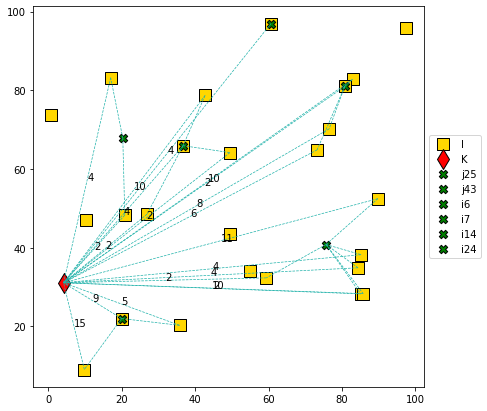

In [133]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (7, 7))
                
        fig.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 150, label = 'I')
        fig.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
                                marker = 'd', s = 200, label = 'K')
       
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        (J.loc[indices_x[2], 'Longtitude'], I.loc[indices_x[0], 'Longtitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        (I.loc[indices_x[0], 'Longtitude'], K.loc[indices_x[1], 'Longtitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                (K.loc[indices_x[1], 'Longtitude'] + I.loc[indices_x[0], 'Longtitude'])/2))
                                #fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                #(J.loc[indices_x[2], 'Longtitude'] + I.loc[indices_x[0], 'Longtitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longtitude'], color = 'green',
                                        edgecolors = 'black', s = 70, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

In [134]:
for v in model_det.getVars():
        if v.xn > 0:
            if v.varName.startswith('x_ikj'):
                indices_x = v.varName[6:-1].split(',')
indices_x

['i24', 'k0', 'i24']

Probabilistic model

In [135]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.99

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))

g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = up_bound * 4

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [136]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [137]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [138]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')

{('k0', 'j35', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j35', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j35', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j43', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j43', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j43', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j63', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j63', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j63', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j63', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j67', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j67', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j67', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j67', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j68', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j68', 'i16'): <gurobi.Constr *Aw

In [139]:
model_prob.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1352 rows, 4376 columns and 1399427 nonzeros


Model fingerprint: 0xdc9aa5a4
Variable types: 0 continuous, 4376 integer (1326 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 2e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 10340.000000
Presolve removed 1215 rows and 3927 columns
Presolve time: 0.69s
Presolved: 137 rows, 449 columns, 807 nonzeros
Variable types: 0 continuous, 449 integer (113 binary)

Root relaxation: objective 4.224000e+03, 305 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4224.00000    0   12 10340.0000 4224.00000  59.1%     -    0s
H    0     0                    6840.0000000 4224.00000  38.2%     -    0s
H    0     0                    6540.0

In [140]:
ListSolution(model_prob)

Number of solutions found: 10
0
5340 
x_ikj[i0,k0,i4] 14
x_ikj[i1,k0,j72] 6
x_ikj[i2,k0,i22] 6
x_ikj[i3,k0,j40] 11
x_ikj[i4,k0,i4] 8
x_ikj[i5,k0,j40] 15
x_ikj[i6,k0,i19] 18
x_ikj[i7,k0,j83] 12
x_ikj[i8,k0,i8] 6
x_ikj[i9,k0,i8] 12
x_ikj[i10,k0,i24] 18
x_ikj[i11,k0,j72] 9
x_ikj[i12,k0,j83] 17
x_ikj[i14,k0,j83] 8
x_ikj[i15,k0,j72] 4
x_ikj[i16,k0,i24] 4
x_ikj[i17,k0,i22] 4
x_ikj[i18,k0,j72] 14
x_ikj[i19,k0,i19] 19
x_ikj[i20,k0,i4] 18
x_ikj[i21,k0,i4] 6
x_ikj[i22,k0,i24] 8
x_ikj[i23,k0,j40] 15
x_ikj[i23,k0,i4] 4
x_ikj[i24,k0,i24] 8
y_j[j40] 1
y_j[j72] 1
y_j[j83] 1
y_j[i4] 1
y_j[i8] 1
y_j[i19] 1
y_j[i22] 1
y_j[i24] 1


1
5440 
x_ikj[i0,k0,i4] 14
x_ikj[i1,k0,j72] 6
x_ikj[i2,k0,i22] 6
x_ikj[i3,k0,j40] 11
x_ikj[i4,k0,i4] 8
x_ikj[i5,k0,j40] 15
x_ikj[i6,k0,i19] 18
x_ikj[i7,k0,j83] 12
x_ikj[i8,k0,i8] 6
x_ikj[i9,k0,i8] 12
x_ikj[i10,k0,i24] 18
x_ikj[i11,k0,j72] 9
x_ikj[i12,k0,j83] 17
x_ikj[i14,k0,j83] 8
x_ikj[i15,k0,j72] 4
x_ikj[i16,k0,i24] 4
x_ikj[i17,k0,i22] 4
x_ikj[i18,k0,j72] 14
x_ikj[i19,k0,i19

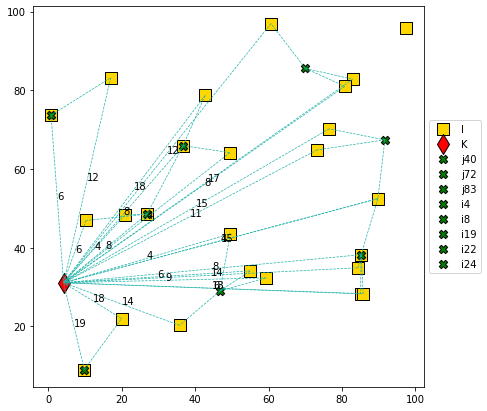

In [141]:
SolutionGraph(I, K, J, model_prob)

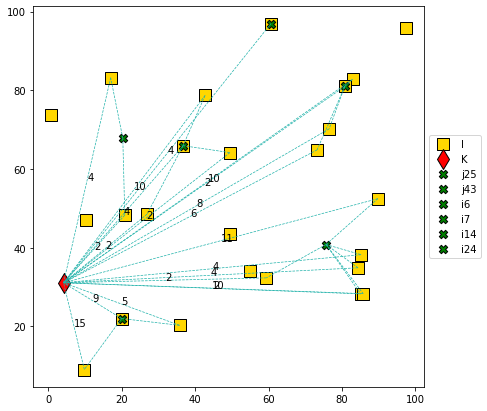

In [142]:
SolutionGraph(I, K, J, model_det)

Probabilistic model with relaxed constraints

In [143]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [144]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j2'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j68'),

In [145]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [146]:
#Redefine constants and random variables


I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))

In [147]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [148]:
model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')


model_prob_rel.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob_rel.optimize()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1404 rows, 4476 columns and 1457737 nonzeros
Model fingerprint: 0xcbfd2805
Variable types: 0 continuous, 4476 integer (1326 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 2e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 11980.000000
Presolve removed 1262 rows and 4009 columns
Presolve time: 0.76s
Presolved: 142 rows, 467 columns, 840 nonzeros
Variable types: 0 continuous, 467 integer (117 binary)

Root relaxation: objective 4.448000e+03, 319 itera

In [151]:
ListSolution(model_prob_rel)

Number of solutions found: 6
0
5680 
x_ikj[i0,k0,j69] 8
x_ikj[i0,k0,i21] 6
x_ikj[i1,k0,j72] 6
x_ikj[i2,k0,i22] 6
x_ikj[i3,k0,j69] 11
x_ikj[i4,k0,j69] 8
x_ikj[i5,k0,j69] 4
x_ikj[i5,k0,i12] 11
x_ikj[i6,k0,i6] 18
x_ikj[i7,k0,i7] 12
x_ikj[i8,k0,i8] 6
x_ikj[i9,k0,i8] 12
x_ikj[i10,k0,i16] 18
x_ikj[i11,k0,j72] 9
x_ikj[i12,k0,i12] 17
x_ikj[i13,k0,i12] 14
x_ikj[i14,k0,i12] 8
x_ikj[i15,k0,j72] 4
x_ikj[i16,k0,i16] 4
x_ikj[i17,k0,i22] 4
x_ikj[i18,k0,j72] 14
x_ikj[i19,k0,i6] 19
x_ikj[i20,k0,i21] 18
x_ikj[i21,k0,i21] 6
x_ikj[i22,k0,i22] 8
x_ikj[i23,k0,j69] 19
x_ikj[i24,k0,i22] 8
y_j[j69] 1
y_j[j72] 1
y_j[i6] 1
y_j[i7] 1
y_j[i8] 1
y_j[i12] 1
y_j[i16] 1
y_j[i21] 1
y_j[i22] 1


1
5780 
x_ikj[i0,k0,j69] 8
x_ikj[i0,k0,i21] 6
x_ikj[i1,k0,j72] 6
x_ikj[i2,k0,i22] 6
x_ikj[i3,k0,j69] 11
x_ikj[i4,k0,j69] 8
x_ikj[i5,k0,j69] 4
x_ikj[i5,k0,i12] 11
x_ikj[i6,k0,i6] 18
x_ikj[i7,k0,i7] 12
x_ikj[i8,k0,i8] 6
x_ikj[i9,k0,i8] 12
x_ikj[i10,k0,i16] 18
x_ikj[i11,k0,j72] 9
x_ikj[i12,k0,i12] 17
x_ikj[i13,k0,i12] 14
x_ikj[i14,

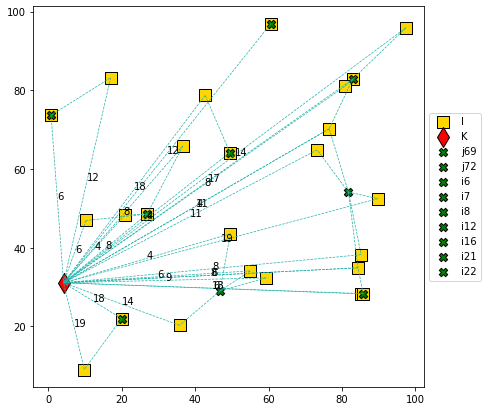

In [150]:
SolutionGraph(I, K, J, model_prob_rel)

1) complete information optimum - lower bound for optimum
2) price of uncertainty